In [1]:
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive/', force_remount=True)

# !ls /content/drive

# # we placed the files in our pc here, put it in comment so it won't interfere with your loading
# %cd "/content/drive/My Drive/שיעורים פרטיי/ג'וליה FMRI/עבודת הגשה סופית"

%cd G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית

G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית


In [2]:
import scipy.io as sio
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tqdm import tqdm

שליפת נתונים נדרשים לטובת המסווגים

In [3]:
def extract_start_end_features(mat_path, var_name):
    """
    Extracts start and end 5-second segments from fMRI movie data for classification.
    Returns: X_start, Y_start, X_end, Y_end
    """
    mat = sio.loadmat(mat_path)
    data = mat[var_name]  # shape: [170, 14, 50, regions]

    X_start, Y_start = [], []
    X_end, Y_end = [], []

    for subj in range(data.shape[0]):
        for clip in range(data.shape[1]):
            clip_data = data[subj, clip, :, :]  # shape: [50, regions]

            start = clip_data[0:5, :].flatten()
            end = clip_data[45:50, :].flatten()

            X_start.append(start)
            Y_start.append(clip + 1)

            X_end.append(end)
            Y_end.append(clip + 1)

    return (
        np.array(X_start), np.array(Y_start),
        np.array(X_end), np.array(Y_end)
    )


ייצוג המידע

In [4]:
# path_VIS = '/content/drive/MyDrive/data_movie_VIS.mat'
# path_DAN = '/content/drive/MyDrive/data_movie_DAN.mat'
# path_DMN = '/content/drive/MyDrive/Files_fmri_ final_project/data_movie_DMN.mat'


path_VIS = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_movie_VIS.mat"
path_DAN = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_movie_DAN.mat"
path_DMN = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_movie_DMN.mat"


X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end = extract_start_end_features(path_VIS, 'data_movie_VIS')
X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end = extract_start_end_features(path_DAN, 'data_movie_DAN')
X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end = extract_start_end_features(path_DMN, 'data_movie_DMN')

print("VIS start:", X_VIS_start.shape, Y_VIS_start.shape)
print("VIS end:  ", X_VIS_end.shape, Y_VIS_end.shape)
print("DAN start:", X_DAN_start.shape, Y_DAN_start.shape)
print("DAN end:  ", X_DAN_end.shape, Y_DAN_end.shape)
print("DMN start:", X_DMN_start.shape, Y_DMN_start.shape)
print("DMN end:  ", X_DMN_end.shape, Y_DMN_end.shape)

VIS start: (2380, 235) (2380,)
VIS end:   (2380, 235) (2380,)
DAN start: (2380, 170) (2380,)
DAN end:   (2380, 170) (2380,)
DMN start: (2380, 340) (2380,)
DMN end:   (2380, 340) (2380,)


הגדרות כל המסווגים

In [5]:
def run_knn_loocv_full(X_start, Y_start, X_end, Y_end, name=""):
    """
    Runs KNN with Leave-One-Out on start and end segments separately.
    Returns accuracy for each and the predictions for confusion matrices.
    """
    knn = KNeighborsClassifier(n_neighbors=3)
    loo = LeaveOneOut()

    def run_loocv(X, Y, label):
        y_true, y_pred = [], []
        for train_idx, test_idx in tqdm(loo.split(X), total=X.shape[0], desc=f"KNN on {name} {label}"):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]

            knn.fit(X_train, y_train)
            y_hat = knn.predict(X_test)

            y_true.append(y_test[0])
            y_pred.append(y_hat[0])

        acc = accuracy_score(y_true, y_pred)
        print(f"KNN accuracy on {name} {label}: {acc:.3f}")
        return acc, y_true, y_pred

    acc_start, y_true_start, y_pred_start = run_loocv(X_start, Y_start, "Start")
    acc_end, y_true_end, y_pred_end = run_loocv(X_end, Y_end, "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end': {'acc': acc_end, 'y_true': y_true_end, 'y_pred': y_pred_end}
    }

def run_svm_kfold_full(X_start, Y_start, X_end, Y_end, name="", k=5):
    """
    Runs SVM (linear kernel) with K-Fold CV on start and end segments separately.
    Returns accuracy and predictions for both.
    """
    def run_kfold(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = np.clip(X, -10, 10)

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        y_true, y_pred = [], []

        for train_idx, test_idx in tqdm(kf.split(X), total=k, desc=f"SVM on {name} {label}"):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            svm = SVC(kernel='linear')
            svm.fit(X_train, y_train)
            y_hat = svm.predict(X_test)

            y_true.extend(y_test)
            y_pred.extend(y_hat)

        acc = accuracy_score(y_true, y_pred)
        print(f"SVM (k={k}-fold) accuracy on {name} {label}: {acc:.3f}")
        return acc, y_true, y_pred

    acc_start, y_true_start, y_pred_start = run_kfold(X_start, Y_start, "Start")
    acc_end, y_true_end, y_pred_end = run_kfold(X_end, Y_end, "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end': {'acc': acc_end, 'y_true': y_true_end, 'y_pred': y_pred_end}
    }

def run_lda_kfold_full(X_start, Y_start, X_end, Y_end, name="", k=10):
    """
    Runs LDA with K-Fold CV on start and end segments separately.
    Returns accuracy and predictions for both.
    """
    def run_kfold(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = np.clip(X, -10, 10)

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        y_true, y_pred = [], []

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for train_idx, test_idx in tqdm(kf.split(X), total=k, desc=f"LDA on {name} {label}"):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = Y[train_idx], Y[test_idx]

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                lda = LinearDiscriminantAnalysis()
                lda.fit(X_train, y_train)
                y_hat = lda.predict(X_test)

                y_true.extend(y_test)
                y_pred.extend(y_hat)

        acc = accuracy_score(y_true, y_pred)
        print(f"LDA (k={k}-fold) accuracy on {name} {label}: {acc:.3f}")
        return acc, y_true, y_pred

    acc_start, y_true_start, y_pred_start = run_kfold(X_start, Y_start, "Start")
    acc_end, y_true_end, y_pred_end = run_kfold(X_end, Y_end, "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end': {'acc': acc_end, 'y_true': y_true_end, 'y_pred': y_pred_end}
    }

def run_qda_kfold_full(X_start, Y_start, X_end, Y_end, name="", k=10):
    """
    Runs QDA with K-Fold CV on start and end segments separately.
    Returns accuracy and predictions for both.
    """
    def run_kfold(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = np.clip(X, -10, 10)

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        y_true, y_pred = [], []

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for train_idx, test_idx in tqdm(kf.split(X), total=k, desc=f"QDA on {name} {label}"):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = Y[train_idx], Y[test_idx]

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                qda = QuadraticDiscriminantAnalysis()
                qda.fit(X_train, y_train)
                y_hat = qda.predict(X_test)

                y_true.extend(y_test)
                y_pred.extend(y_hat)

        acc = accuracy_score(y_true, y_pred)
        print(f"QDA (k={k}-fold) accuracy on {name} {label}: {acc:.3f}")
        return acc, y_true, y_pred

    acc_start, y_true_start, y_pred_start = run_kfold(X_start, Y_start, "Start")
    acc_end, y_true_end, y_pred_end = run_kfold(X_end, Y_end, "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end': {'acc': acc_end, 'y_true': y_true_end, 'y_pred': y_pred_end}
    }

def run_nb_loocv_full(X_start, Y_start, X_end, Y_end, name=""):
    """
    Runs Gaussian Naive Bayes with Leave-One-Out CV on start and end segments separately.
    Returns accuracy and predictions for both.
    """
    def run_loocv(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        loo = LeaveOneOut()
        y_true, y_pred = [], []

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for train_idx, test_idx in tqdm(loo.split(X), total=X.shape[0], desc=f"Naive Bayes LOO on {name} {label}"):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = Y[train_idx], Y[test_idx]

                nb = GaussianNB()
                nb.fit(X_train, y_train)
                y_hat = nb.predict(X_test)

                y_true.append(y_test[0])
                y_pred.append(y_hat[0])

        acc = accuracy_score(y_true, y_pred)
        print(f"Naive Bayes (LOO) accuracy on {name} {label}: {acc:.3f}")
        return acc, y_true, y_pred

    acc_start, y_true_start, y_pred_start = run_loocv(X_start, Y_start, "Start")
    acc_end, y_true_end, y_pred_end = run_loocv(X_end, Y_end, "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end': {'acc': acc_end, 'y_true': y_true_end, 'y_pred': y_pred_end}
    }


In [27]:
knn_results_VIS = run_knn_loocv_full(X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end, name="VIS")
knn_results_DAN = run_knn_loocv_full(X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end, name="DAN")
knn_results_DMN = run_knn_loocv_full(X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end, name="DMN")

KNN on VIS Start:   0%|          | 0/2380 [00:00<?, ?it/s]

KNN on VIS Start:  82%|████████▏ | 1942/2380 [00:03<00:00, 485.31it/s]c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:314: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:314: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:314: RuntimeWarning: invalid value en

KNN accuracy on VIS Start: 0.250


KNN on VIS End:  83%|████████▎ | 1965/2380 [00:03<00:00, 521.44it/s]c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:314: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:314: RuntimeWarning: invalid value encountered in add
  distances += XX
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:315: RuntimeWarning: invalid value enco

KNN accuracy on VIS End: 0.258


KNN on DAN End:   6%|▌         | 142/2380 [00:00<00:03, 698.94it/s]

KNN accuracy on DAN Start: 0.268


KNN on DMN Start:   1%|▏         | 30/2380 [00:00<00:07, 294.14it/s]

KNN accuracy on DAN End: 0.304


KNN on DMN End:   3%|▎         | 71/2380 [00:00<00:06, 353.49it/s]

KNN accuracy on DMN Start: 0.587


KNN on DMN End: 100%|██████████| 2380/2380 [00:06<00:00, 348.72it/s]

KNN accuracy on DMN End: 0.568


In [28]:
svm_results_VIS = run_svm_kfold_full(X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end, name="VIS")
svm_results_DAN = run_svm_kfold_full(X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end, name="DAN")
svm_results_DMN = run_svm_kfold_full(X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end, name="DMN")


SVM on VIS End:   0%|          | 0/5 [00:00<?, ?it/s]

SVM (k=5-fold) accuracy on VIS Start: 0.452


SVM on DAN Start:   0%|          | 0/5 [00:00<?, ?it/s]

SVM (k=5-fold) accuracy on VIS End: 0.455


SVM on DAN End:   0%|          | 0/5 [00:00<?, ?it/s]

SVM (k=5-fold) accuracy on DAN Start: 0.476


SVM on DMN Start:   0%|          | 0/5 [00:00<?, ?it/s]

SVM (k=5-fold) accuracy on DAN End: 0.510


SVM on DMN End:   0%|          | 0/5 [00:00<?, ?it/s]

SVM (k=5-fold) accuracy on DMN Start: 0.792


SVM on DMN End: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

SVM (k=5-fold) accuracy on DMN End: 0.766


In [29]:
lda_results_VIS = run_lda_kfold_full(X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end, name="VIS")
lda_results_DAN = run_lda_kfold_full(X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end, name="DAN")
lda_results_DMN = run_lda_kfold_full(X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end, name="DMN")


LDA on VIS End:  20%|██        | 2/10 [00:00<00:00, 18.16it/s]

LDA (k=10-fold) accuracy on VIS Start: 0.523


LDA on DAN Start:  30%|███       | 3/10 [00:00<00:00, 29.38it/s]

LDA (k=10-fold) accuracy on VIS End: 0.543


LDA on DAN End:  40%|████      | 4/10 [00:00<00:00, 33.58it/s]

LDA (k=10-fold) accuracy on DAN Start: 0.555


LDA on DMN Start:  20%|██        | 2/10 [00:00<00:00, 13.97it/s]

LDA (k=10-fold) accuracy on DAN End: 0.597


LDA on DMN End:  20%|██        | 2/10 [00:00<00:00, 14.91it/s]

LDA (k=10-fold) accuracy on DMN Start: 0.861


LDA on DMN End: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]

LDA (k=10-fold) accuracy on DMN End: 0.842


In [30]:
qda_results_VIS = run_qda_kfold_full(X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end, name="VIS")
qda_results_DAN = run_qda_kfold_full(X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end, name="DAN")
qda_results_DMN = run_qda_kfold_full(X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end, name="DMN")


QDA on VIS Start:   0%|          | 0/10 [00:00<?, ?it/s]

QDA on VIS End:  20%|██        | 2/10 [00:00<00:00, 16.55it/s]

QDA (k=10-fold) accuracy on VIS Start: 0.070


QDA on DAN Start:  20%|██        | 2/10 [00:00<00:00, 19.98it/s]

QDA (k=10-fold) accuracy on VIS End: 0.068


QDA on DAN End:  30%|███       | 3/10 [00:00<00:00, 20.98it/s]

QDA (k=10-fold) accuracy on DAN Start: 0.071


QDA on DMN Start:  20%|██        | 2/10 [00:00<00:00, 13.20it/s]

QDA (k=10-fold) accuracy on DAN End: 0.075


QDA on DMN End:  20%|██        | 2/10 [00:00<00:00, 13.00it/s]

QDA (k=10-fold) accuracy on DMN Start: 0.074


QDA on DMN End: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s]

QDA (k=10-fold) accuracy on DMN End: 0.079


In [31]:
nb_results_VIS = run_nb_loocv_full(X_VIS_start, Y_VIS_start, X_VIS_end, Y_VIS_end, name="VIS")
nb_results_DAN = run_nb_loocv_full(X_DAN_start, Y_DAN_start, X_DAN_end, Y_DAN_end, name="DAN")
nb_results_DMN = run_nb_loocv_full(X_DMN_start, Y_DMN_start, X_DMN_end, Y_DMN_end, name="DMN")

Naive Bayes LOO on VIS End:   1%|          | 23/2380 [00:00<00:10, 222.32it/s]

Naive Bayes (LOO) accuracy on VIS Start: 0.071


Naive Bayes LOO on DAN Start:   1%|          | 26/2380 [00:00<00:09, 254.95it/s]

Naive Bayes (LOO) accuracy on VIS End: 0.071


Naive Bayes LOO on DAN End:   1%|          | 27/2380 [00:00<00:08, 269.84it/s]

Naive Bayes (LOO) accuracy on DAN Start: 0.318


Naive Bayes LOO on DMN Start:   1%|          | 17/2380 [00:00<00:14, 162.91it/s]

Naive Bayes (LOO) accuracy on DAN End: 0.350


Naive Bayes LOO on DMN End:   1%|▏         | 33/2380 [00:00<00:14, 158.72it/s]

Naive Bayes (LOO) accuracy on DMN Start: 0.530


Naive Bayes LOO on DMN End: 100%|██████████| 2380/2380 [00:15<00:00, 157.33it/s]

Naive Bayes (LOO) accuracy on DMN End: 0.545


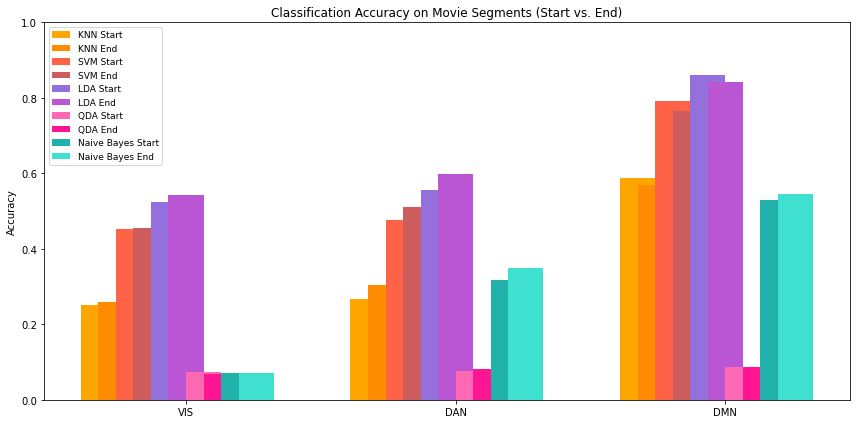

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names
classifiers = ['KNN', 'SVM', 'LDA', 'QDA', 'Naive Bayes']
regions = ['VIS', 'DAN', 'DMN']

# Accuracy values (start and end for each classifier in each region)
accuracy_data = {
    'KNN':         {'Start': [0.250, 0.268, 0.587], 'End': [0.258, 0.304, 0.568]},
    'SVM':         {'Start': [0.452, 0.476, 0.792], 'End': [0.455, 0.510, 0.766]},
    'LDA':         {'Start': [0.523, 0.555, 0.861], 'End': [0.543, 0.597, 0.842]},
    'QDA':         {'Start': [0.074, 0.077, 0.087], 'End': [0.069, 0.082, 0.088]},
    'Naive Bayes': {'Start': [0.071, 0.318, 0.530], 'End': [0.071, 0.350, 0.545]},
}

# Bar plot settings
x = np.arange(len(regions))
width = 0.13

fig, ax = plt.subplots(figsize=(12, 6))

# Define distinct colors
colors_start = ['#FFA500', '#FF6347', '#9370DB', '#FF69B4', '#20B2AA']
colors_end   = ['#FF8C00', '#CD5C5C', '#BA55D3', '#FF1493', '#40E0D0']

# Plot bars
for i, clf in enumerate(classifiers):
    acc_start = accuracy_data[clf]['Start']
    acc_end = accuracy_data[clf]['End']
    ax.bar(x + i*width - width*2.5, acc_start, width, label=f'{clf} Start', color=colors_start[i])
    ax.bar(x + i*width - width*2.5 + width/2, acc_end, width, label=f'{clf} End', color=colors_end[i])

# Formatting
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy on Movie Segments (Start vs. End)')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.set_ylim([0, 1])
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()


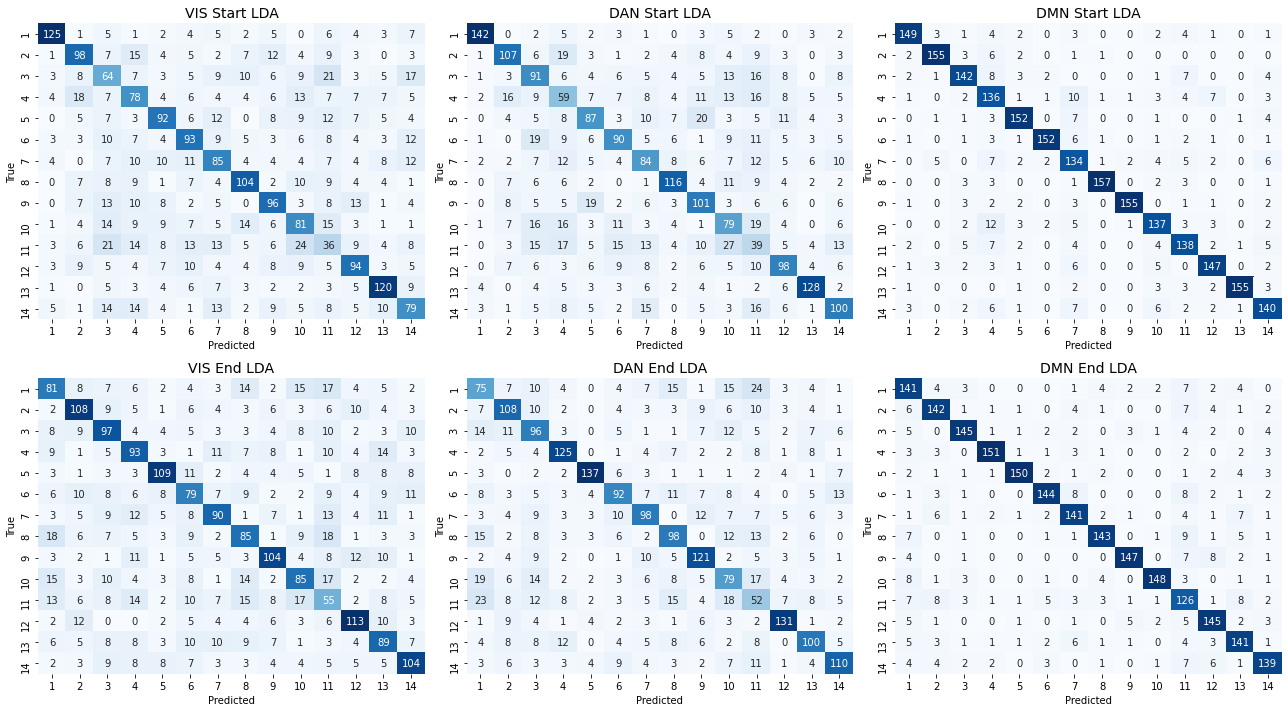

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract all y_true and y_pred from lda results
matrices = {
    "VIS Start LDA": (lda_results_VIS['start']['y_true'], lda_results_VIS['start']['y_pred']),
    "DAN Start LDA": (lda_results_DAN['start']['y_true'], lda_results_DAN['start']['y_pred']),
    "DMN Start LDA": (lda_results_DMN['start']['y_true'], lda_results_DMN['start']['y_pred']),
    "VIS End LDA":   (lda_results_VIS['end']['y_true'],   lda_results_VIS['end']['y_pred']),
    "DAN End LDA":   (lda_results_DAN['end']['y_true'],   lda_results_DAN['end']['y_pred']),
    "DMN End LDA":   (lda_results_DMN['end']['y_true'],   lda_results_DMN['end']['y_pred']),
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (title, (y_true, y_pred)) in zip(axes, matrices.items()):
    cm = confusion_matrix(y_true, y_pred, labels=range(1, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=range(1, 15), yticklabels=range(1, 15), cbar=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


**Interim Report – fMRI-Based Movie Classification Using Machine Learning**

**Objective:**

The goal of this experiment is to classify which of 14 movie clips each subject watched, based on fMRI activity measured during the first and last 5 seconds of each movie.
Classification was performed based on three key brain networks:
VIS - Visual network
DAN - Dorsal attention network
DMN - Default mode network

Five classifiers were compared:KNN, SVM, LDA, QDA, Naive Bayes

**Overall Classifier Performance (Bar Plot Summary):**

**LDA** consistently outperformed other classifiers across all brain regions and both time segments.

**SVM** achieved the second-best results, with up to 79% accuracy on DMN Start.

**KNN** showed decent performance but was generally inferior to LDA and SVM.

**Naive Bayes** performed surprisingly well on DMN (53–54%) but failed in other regions.

**QDA** failed almost entirely (7–8% accuracy), likely due to ill-conditioned covariance matrices.

General Trend:
Classifier accuracy improved as the brain network reflected more higher-order cognitive processing:
DMN > DAN > VIS

**Network-Based Analysis – LDA Classifier Results:**

| Brain Network | Movie Start | Movie End |
| ------------- | ----------- | --------- |
| VIS           | 52.3%       | 54.3%     |
| DAN           | 55.5%       | 59.7%     |
| DMN           | **86.1%**   | **84.2%** |

**VIS – Visual Network:**

*   Lower accuracy – likely due to similar visual patterns across different movies.

*   Small difference between start and end of the movie, suggesting uniform activation.

**DAN – Dorsal Attention Network:**
More accurate than VIS, especially at movie end – may indicate heightened attention or engagement toward the conclusion of the clip

**DMN – Default Mode Network:**

*   Highest accuracy across the board – likely due to its role in semantic, emotional, and introspective processing

*   Minimal difference between start and end → implies consistent, content-specific information representation

**Key Takeaways:**

*   LDA is the most effective classifier in this task – accurate, stable, and efficient.

*   The DMN provides the richest information for distinguishing between movie types.

No single network suffices across all cases – integrating multiple networks and smarter models may improve results.


חלק 2: סיווג לפי קטעי מנוחה


In [6]:
# rest_path_VIS = "/content/drive/MyDrive/data_rest_VIS.mat"
# rest_path_DAN = "/content/drive/MyDrive/data_rest_DAN.mat"
# rest_path_DMN = "/content/drive/MyDrive/data_rest_DMN.mat"

rest_path_VIS = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_rest_VIS.mat"
rest_path_DAN = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_rest_DAN.mat"
rest_path_DMN = r"G:\My Drive\שיעורים פרטיים\ג'וליה FMRI\עבודת הגשה סופית\data_rest_DMN.mat"


# Load each file and extract the variables
rest_data_VIS = sio.loadmat(rest_path_VIS)['data_rest_VIS']
rest_data_DAN = sio.loadmat(rest_path_DAN)['data_rest_DAN']
rest_data_DMN = sio.loadmat(rest_path_DMN)['data_rest_DMN']

# Step 3: Check shapes
print("VIS rest shape:", rest_data_VIS.shape)
print("DAN rest shape:", rest_data_DAN.shape)
print("DMN rest shape:", rest_data_DMN.shape)


VIS rest shape: (170, 14, 19, 47)
DAN rest shape: (170, 14, 19, 34)
DMN rest shape: (170, 14, 19, 68)


In [7]:
def extract_rest_features_labels(rest_data, var_name):
    """
    Extracts features and labels from resting-state fMRI data.

    Parameters:
        rest_data (np.ndarray): 4D array with shape (subjects, clips, time, regions)
        var_name (str): Just for labeling, not functionally used

    Returns:
        X_start (np.ndarray): Flattened features from first 5s [samples, features]
        Y_start (np.ndarray): Corresponding labels [samples]
        X_end (np.ndarray): Flattened features from last 5s [samples, features]
        Y_end (np.ndarray): Corresponding labels [samples]
    """
    X_start, Y_start = [], []
    X_end, Y_end = [], []

    for subj in range(rest_data.shape[0]):       # 170 subjects
        for clip in range(rest_data.shape[1]):   # 14 clips/rest periods
            segment = rest_data[subj, clip, :, :]  # shape (19, regions)

            start = segment[0:5, :]    # seconds 0–4
            end = segment[14:19, :]    # seconds 14–18

            X_start.append(start.flatten())
            Y_start.append(clip + 1)

            X_end.append(end.flatten())
            Y_end.append(clip + 1)

    return (
        np.array(X_start), np.array(Y_start),
        np.array(X_end), np.array(Y_end)
    )



In [8]:
# Use the previous function to extract features from resting-state data
X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end = extract_rest_features_labels(rest_data_VIS, "VIS")
X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end = extract_rest_features_labels(rest_data_DAN, "DAN")
X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end = extract_rest_features_labels(rest_data_DMN, "DMN")

# Display the shapes
(
    X_VIS_rest_start.shape, X_VIS_rest_end.shape,
    X_DAN_rest_start.shape, X_DAN_rest_end.shape,
    X_DMN_rest_start.shape, X_DMN_rest_end.shape
)

((2380, 235), (2380, 235), (2380, 170), (2380, 170), (2380, 340), (2380, 340))

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LeaveOneOut, cross_val_predict

def run_svm_loocv_full(X_start, Y_start, X_end, Y_end, name=""):
    """
    Runs SVM (linear kernel) with LOOCV on start and end segments separately,
    parallelized over all CPU cores.
    Returns accuracy and predictions for both.
    """
    def run_loocv(X, Y, label):
        # replace NaNs/infs
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        # build a pipeline: scaler → linear SVM
        pipe = make_pipeline(
            StandardScaler(),
            SVC(kernel='linear')
        )

        loo = LeaveOneOut()

        # cross_val_predict will spawn jobs across CPU cores
        y_pred = cross_val_predict(
            pipe,
            X,
            Y,
            cv=loo,
            n_jobs=-1, # =-1 for all cores
            verbose=1  # optional: prints progress
        )

        acc = accuracy_score(Y, y_pred)
        print(f"SVM (LOO) accuracy on {name} {label}: {acc:.3f}")
        return acc, list(Y), list(y_pred)

    acc_start, y_true_start, y_pred_start = run_loocv(X_start, Y_start, "Start")
    acc_end,   y_true_end,   y_pred_end   = run_loocv(X_end,   Y_end,   "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end':   {'acc': acc_end,   'y_true': y_true_end,   'y_pred': y_pred_end}
    }


def run_lda_loocv_full(X_start, Y_start, X_end, Y_end, name=""):
    """
    Runs LDA with LOOCV on start and end segments separately,
    parallelized over all CPU cores.
    Returns accuracy and predictions for both.
    """
    def run_loocv(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        
        pipe = make_pipeline(
            StandardScaler(),
            LinearDiscriminantAnalysis()
        )

        loo = LeaveOneOut()
        # cross_val_predict will spawn jobs across CPU cores
        y_pred = cross_val_predict(
            pipe,
            X,
            Y,
            cv=loo,
            n_jobs=-1, # =-1 for all cores
            verbose=1  # optional: prints progress
        )

        acc = accuracy_score(Y, y_pred)
        print(f"LDA (LOO) accuracy on {name} {label}: {acc:.3f}")
        return acc, list(Y), list(y_pred)
    
    acc_start, y_true_start, y_pred_start = run_loocv(X_start, Y_start, "Start")
    acc_end,   y_true_end,   y_pred_end   = run_loocv(X_end,   Y_end,   "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end':   {'acc': acc_end,   'y_true': y_true_end,   'y_pred': y_pred_end}
    }

def run_qda_loocv_full(X_start, Y_start, X_end, Y_end, name=""):
    """
    Runs QDA with LOOCV on start and end segments separately,
    parallelized over all CPU cores.
    Returns accuracy and predictions for both.
    """
    def run_loocv(X, Y, label):
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        
        pipe = make_pipeline(
            StandardScaler(),
            QuadraticDiscriminantAnalysis()
        )

        loo = LeaveOneOut()
        # cross_val_predict will spawn jobs across CPU cores
        y_pred = cross_val_predict(
            pipe,
            X,
            Y,
            cv=loo,
            n_jobs=-1, # =-1 for all cores
            verbose=1  # optional: prints progress
        )

        acc = accuracy_score(Y, y_pred)
        print(f"QDA (LOO) accuracy on {name} {label}: {acc:.3f}")
        return acc, list(Y), list(y_pred)
    
    acc_start, y_true_start, y_pred_start = run_loocv(X_start, Y_start, "Start")
    acc_end,   y_true_end,   y_pred_end   = run_loocv(X_end,   Y_end,   "End")

    return {
        'start': {'acc': acc_start, 'y_true': y_true_start, 'y_pred': y_pred_start},
        'end':   {'acc': acc_end,   'y_true': y_true_end,   'y_pred': y_pred_end}
    }

In [38]:
knn_rest_VIS = run_knn_loocv_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
knn_rest_DAN = run_knn_loocv_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
knn_rest_DMN = run_knn_loocv_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")


KNN on VIS Rest End:   4%|▍         | 90/2380 [00:00<00:05, 449.34it/s]

KNN accuracy on VIS Rest Start: 0.254


KNN on DAN Rest Start:   6%|▌         | 148/2380 [00:00<00:03, 721.64it/s]

KNN accuracy on VIS Rest End: 0.091


KNN on DAN Rest End:   6%|▌         | 132/2380 [00:00<00:03, 654.80it/s]

KNN accuracy on DAN Rest Start: 0.270


KNN on DMN Rest Start:   2%|▏         | 41/2380 [00:00<00:06, 389.24it/s]

KNN accuracy on DAN Rest End: 0.092


KNN on DMN Rest End:   2%|▏         | 38/2380 [00:00<00:06, 378.39it/s]

KNN accuracy on DMN Rest Start: 0.531


KNN on DMN Rest End: 100%|██████████| 2380/2380 [00:06<00:00, 363.73it/s]

KNN accuracy on DMN Rest End: 0.133


In [10]:
# svm_rest_VIS = run_svm_kfold_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
# svm_rest_DAN = run_svm_kfold_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
# svm_rest_DMN = run_svm_kfold_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")

# LOO for section 2
svm_rest_VIS = run_svm_loocv_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
svm_rest_DAN = run_svm_loocv_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
svm_rest_DMN = run_svm_loocv_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   17.0s


KeyboardInterrupt: 

In [ ]:
# lda_rest_VIS = run_lda_kfold_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
# lda_rest_DAN = run_lda_kfold_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
# lda_rest_DMN = run_lda_kfold_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")

# LOO for section 2
lda_rest_VIS = run_lda_loocv_full(
    X_VIS_rest_start, Y_VIS_rest_start,
    X_VIS_rest_end,   Y_VIS_rest_end,
    name="VIS Rest"
)

lda_rest_DAN = run_lda_loocv_full(
    X_DAN_rest_start, Y_DAN_rest_start,
    X_DAN_rest_end,   Y_DAN_rest_end,
    name="DAN Rest"
)

lda_rest_DMN = run_lda_loocv_full(
    X_DMN_rest_start, Y_DMN_rest_start,
    X_DMN_rest_end,   Y_DMN_rest_end,
    name="DMN Rest"
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 322 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done 822 tasks      | elapsed:   14.1s
[Parallel(n_jobs=6)]: Done 1522 tasks      | elapsed:   24.8s
[Parallel(n_jobs=6)]: Done 2369 out of 2380 | elapsed:   37.6s remaining:    0.1s
[Parallel(n_jobs=6)]: Done 2380 out of 2380 | elapsed:   37.7s finished


LDA (LOO) accuracy on VIS Rest Start: 0.510


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   13.4s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   24.2s
[Parallel(n_jobs=6)]: Done 2380 out of 2380 | elapsed:   36.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LDA (LOO) accuracy on VIS Rest End: 0.141


[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done 1692 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 2380 out of 2380 | elapsed:   24.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LDA (LOO) accuracy on DAN Rest Start: 0.516


[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:    7.1s
[Parallel(n_jobs=6)]: Done 1692 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 2369 out of 2380 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done 2380 out of 2380 | elapsed:   24.3s finished


LDA (LOO) accuracy on DAN Rest End: 0.174


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   20.5s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   36.8s
[Parallel(n_jobs=6)]: Done 2369 out of 2380 | elapsed:   55.8s remaining:    0.2s
[Parallel(n_jobs=6)]: Done 2380 out of 2380 | elapsed:   55.9s finished


LDA (LOO) accuracy on DMN Rest Start: 0.793


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   20.1s


In [ ]:
qda_rest_VIS = run_qda_kfold_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
qda_rest_DAN = run_qda_kfold_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
qda_rest_DMN = run_qda_kfold_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")

# LOO for section 2
qda_rest_VIS = run_qda_loocv_full(
    X_VIS_rest_start, Y_VIS_rest_start,
    X_VIS_rest_end,   Y_VIS_rest_end,
    name="VIS Rest"
)

qda_rest_DAN = run_qda_loocv_full(
    X_DAN_rest_start, Y_DAN_rest_start,
    X_DAN_rest_end,   Y_DAN_rest_end,
    name="DAN Rest"
)

qda_rest_DMN = run_qda_loocv_full(
    X_DMN_rest_start, Y_DMN_rest_start,
    X_DMN_rest_end,   Y_DMN_rest_end,
    name="DMN Rest"
)

QDA on VIS Rest End:  20%|██        | 2/10 [00:00<00:00, 16.85it/s]

QDA (k=10-fold) accuracy on VIS Rest Start: 0.076


QDA on DAN Rest Start:  20%|██        | 2/10 [00:00<00:00, 19.38it/s]

QDA (k=10-fold) accuracy on VIS Rest End: 0.073


QDA on DAN Rest End:  30%|███       | 3/10 [00:00<00:00, 20.23it/s]

QDA (k=10-fold) accuracy on DAN Rest Start: 0.078


QDA on DMN Rest Start:  20%|██        | 2/10 [00:00<00:00, 12.76it/s]

QDA (k=10-fold) accuracy on DAN Rest End: 0.078


QDA on DMN Rest End:  20%|██        | 2/10 [00:00<00:00, 12.80it/s]

QDA (k=10-fold) accuracy on DMN Rest Start: 0.072


QDA on DMN Rest End: 100%|██████████| 10/10 [00:00<00:00, 12.27it/s]

QDA (k=10-fold) accuracy on DMN Rest End: 0.075


In [ ]:
nb_rest_VIS = run_nb_loocv_full(X_VIS_rest_start, Y_VIS_rest_start, X_VIS_rest_end, Y_VIS_rest_end, name="VIS Rest")
nb_rest_DAN = run_nb_loocv_full(X_DAN_rest_start, Y_DAN_rest_start, X_DAN_rest_end, Y_DAN_rest_end, name="DAN Rest")
nb_rest_DMN = run_nb_loocv_full(X_DMN_rest_start, Y_DMN_rest_start, X_DMN_rest_end, Y_DMN_rest_end, name="DMN Rest")


Naive Bayes LOO on VIS Rest End:   1%|          | 24/2380 [00:00<00:09, 239.59it/s]

Naive Bayes (LOO) accuracy on VIS Rest Start: 0.355


Naive Bayes LOO on DAN Rest Start:   2%|▏         | 54/2380 [00:00<00:08, 266.25it/s]

Naive Bayes (LOO) accuracy on VIS Rest End: 0.151


Naive Bayes LOO on DAN Rest End:   1%|          | 29/2380 [00:00<00:08, 286.56it/s]

Naive Bayes (LOO) accuracy on DAN Rest Start: 0.358


Naive Bayes LOO on DMN Rest Start:   2%|▏         | 37/2380 [00:00<00:13, 179.73it/s]

Naive Bayes (LOO) accuracy on DAN Rest End: 0.152


Naive Bayes LOO on DMN Rest End:   1%|          | 18/2380 [00:00<00:13, 170.20it/s]

Naive Bayes (LOO) accuracy on DMN Rest Start: 0.498


Naive Bayes LOO on DMN Rest End: 100%|██████████| 2380/2380 [00:13<00:00, 175.28it/s]

Naive Bayes (LOO) accuracy on DMN Rest End: 0.192


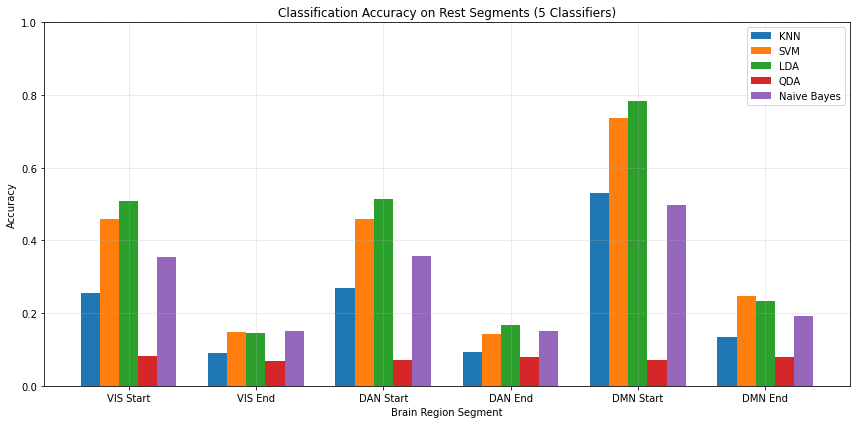

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the x-axis
regions = ['VIS Start', 'VIS End', 'DAN Start', 'DAN End', 'DMN Start', 'DMN End']
x = np.arange(len(regions))

# Accuracy data for each classifier
accuracies = {
    'KNN':         [0.254, 0.091, 0.270, 0.092, 0.531, 0.133],
    'SVM':         [0.461, 0.150, 0.454, 0.153, 0.733, 0.246],
    'LDA':         [0.509, 0.145, 0.513, 0.166, 0.783, 0.232],
    'QDA':         [0.082, 0.069, 0.071, 0.080, 0.072, 0.078],
    'Naive Bayes': [0.355, 0.151, 0.358, 0.152, 0.498, 0.192]
}

bar_width = 0.15
offsets = np.linspace(-0.3, 0.3, len(accuracies))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each classifier
for i, (classifier, acc) in enumerate(accuracies.items()):
    ax.bar(x + offsets[i], acc, bar_width, label=classifier)

ax.set_xlabel('Brain Region Segment')
ax.set_ylabel('Accuracy')
ax.set_title('Classification Accuracy on Rest Segments (5 Classifiers)')
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.set_ylim(0, 1)
ax.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


Note that unlike the previous section, for some segments, LDA is not the best classifier


In [ ]:
# Extract all y_true and y_pred from lda results
matrices = {
    "VIS Start LDA": (lda_rest_VIS['start']['y_true'], lda_rest_VIS['start']['y_pred']),
    "DAN Start SVM": (svm_rest_DAN['start']['y_true'], svm_rest_DAN['start']['y_pred']),
    "DMN Start LDA": (lda_rest_DMN['start']['y_true'], lda_rest_DMN['start']['y_pred']),
    "VIS End LDA":   (lda_rest_VIS['end']['y_true'],   lda_rest_VIS['end']['y_pred']),
    "DAN End LDA":   (lda_rest_DAN['end']['y_true'],   lda_rest_DAN['end']['y_pred']),
    "DMN End SVM":   (svm_rest_DMN['end']['y_true'],   svm_rest_DMN['end']['y_pred']),
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (title, (y_true, y_pred)) in zip(axes, matrices.items()):
    cm = confusion_matrix(y_true, y_pred, labels=range(1, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=range(1, 15), yticklabels=range(1, 15), cbar=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()